# Static Face Recognition: Leonardo DiCaprio, Emma Stone, Sandra Bullock, and Brad Pitt

The purpose of this project is to built a face recognition algorithm to detect whether the person in an image is Leonardo DiCaprio, Emma Stone, Sandra Bullock, or Brad Pitt. We can expand the scope of the project by adding more people rather than just these four, but for simplicity only these four people will be considered.

Since it will be very expensive to train the model, then transfer learning approach is applied. The model that will be used in this project was taken from OpenFace pre-trained model, in which this model was trained using triplet loss cost function. 

Before we delve into the detail, let's import all the necessary libraries. 

## Load Pre-Trained Model

In [2]:
import numpy as np

import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.layers.core import Dense, Activation, Lambda, Flatten
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.models import load_model
from keras.models import model_from_json
from keras.preprocessing.image import load_img, save_img, img_to_array
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
import os
import matplotlib.image as mpimg

import matplotlib.pyplot as plt

Using TensorFlow backend.


In this project, OpenFace pre-trained model will be used. This model used Inception ResNet V1 architecture and it expects 96x96x3 as an input image. Transfer learning method will be applied on the model weights. As the model architecture, we can replicate the OpenFace model as follows:

In [3]:
image_input = Input(shape=(96, 96, 3))

x = ZeroPadding2D(padding=(3, 3), input_shape=(96, 96, 3))(image_input)
x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
x = BatchNormalization(axis=3, epsilon=0.00001, name='bn1')(x)
x = Activation('relu')(x)
x = ZeroPadding2D(padding=(1, 1))(x)
x = MaxPooling2D(pool_size=3, strides=2)(x)
x = Lambda(lambda x: tf.nn.lrn(x, alpha=1e-4, beta=0.75), name='lrn_1')(x)
x = Conv2D(64, (1, 1), name='conv2')(x)
x = BatchNormalization(axis=3, epsilon=0.00001, name='bn2')(x)
x = Activation('relu')(x)
x = ZeroPadding2D(padding=(1, 1))(x)
x = Conv2D(192, (3, 3), name='conv3')(x)
x = BatchNormalization(axis=3, epsilon=0.00001, name='bn3')(x)
x = Activation('relu')(x)
Lambda(lambda x: tf.nn.lrn(x, alpha=1e-4, beta=0.75), name='lrn_2')(x)
x = ZeroPadding2D(padding=(1, 1))(x)
x = MaxPooling2D(pool_size=3, strides=2)(x)

# Inception3a
inception_3a_3x3 = Conv2D(96, (1, 1), name='inception_3a_3x3_conv1')(x)
inception_3a_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_3x3_bn1')(inception_3a_3x3)
inception_3a_3x3 = Activation('relu')(inception_3a_3x3)
inception_3a_3x3 = ZeroPadding2D(padding=(1, 1))(inception_3a_3x3)
inception_3a_3x3 = Conv2D(128, (3, 3), name='inception_3a_3x3_conv2')(inception_3a_3x3)
inception_3a_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_3x3_bn2')(inception_3a_3x3)
inception_3a_3x3 = Activation('relu')(inception_3a_3x3)

inception_3a_5x5 = Conv2D(16, (1, 1), name='inception_3a_5x5_conv1')(x)
inception_3a_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_5x5_bn1')(inception_3a_5x5)
inception_3a_5x5 = Activation('relu')(inception_3a_5x5)
inception_3a_5x5 = ZeroPadding2D(padding=(2, 2))(inception_3a_5x5)
inception_3a_5x5 = Conv2D(32, (5, 5), name='inception_3a_5x5_conv2')(inception_3a_5x5)
inception_3a_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_5x5_bn2')(inception_3a_5x5)
inception_3a_5x5 = Activation('relu')(inception_3a_5x5)

inception_3a_pool = MaxPooling2D(pool_size=3, strides=2)(x)
inception_3a_pool = Conv2D(32, (1, 1), name='inception_3a_pool_conv')(inception_3a_pool)
inception_3a_pool = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_pool_bn')(inception_3a_pool)
inception_3a_pool = Activation('relu')(inception_3a_pool)
inception_3a_pool = ZeroPadding2D(padding=((3, 4), (3, 4)))(inception_3a_pool)

inception_3a_1x1 = Conv2D(64, (1, 1), name='inception_3a_1x1_conv')(x)
inception_3a_1x1 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_1x1_bn')(inception_3a_1x1)
inception_3a_1x1 = Activation('relu')(inception_3a_1x1)

inception_3a = concatenate([inception_3a_3x3, inception_3a_5x5, inception_3a_pool, inception_3a_1x1], axis=3)

# Inception3b
inception_3b_3x3 = Conv2D(96, (1, 1), name='inception_3b_3x3_conv1')(inception_3a)
inception_3b_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_3x3_bn1')(inception_3b_3x3)
inception_3b_3x3 = Activation('relu')(inception_3b_3x3)
inception_3b_3x3 = ZeroPadding2D(padding=(1, 1))(inception_3b_3x3)
inception_3b_3x3 = Conv2D(128, (3, 3), name='inception_3b_3x3_conv2')(inception_3b_3x3)
inception_3b_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_3x3_bn2')(inception_3b_3x3)
inception_3b_3x3 = Activation('relu')(inception_3b_3x3)

inception_3b_5x5 = Conv2D(32, (1, 1), name='inception_3b_5x5_conv1')(inception_3a)
inception_3b_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_5x5_bn1')(inception_3b_5x5)
inception_3b_5x5 = Activation('relu')(inception_3b_5x5)
inception_3b_5x5 = ZeroPadding2D(padding=(2, 2))(inception_3b_5x5)
inception_3b_5x5 = Conv2D(64, (5, 5), name='inception_3b_5x5_conv2')(inception_3b_5x5)
inception_3b_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_5x5_bn2')(inception_3b_5x5)
inception_3b_5x5 = Activation('relu')(inception_3b_5x5)

inception_3b_pool = Lambda(lambda x: x**2, name='power2_3b')(inception_3a)
inception_3b_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_3b_pool)
inception_3b_pool = Lambda(lambda x: x*9, name='mult9_3b')(inception_3b_pool)
inception_3b_pool = Lambda(lambda x: K.sqrt(x), name='sqrt_3b')(inception_3b_pool)
inception_3b_pool = Conv2D(64, (1, 1), name='inception_3b_pool_conv')(inception_3b_pool)
inception_3b_pool = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_pool_bn')(inception_3b_pool)
inception_3b_pool = Activation('relu')(inception_3b_pool)
inception_3b_pool = ZeroPadding2D(padding=(4, 4))(inception_3b_pool)

inception_3b_1x1 = Conv2D(64, (1, 1), name='inception_3b_1x1_conv')(inception_3a)
inception_3b_1x1 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_1x1_bn')(inception_3b_1x1)
inception_3b_1x1 = Activation('relu')(inception_3b_1x1)

inception_3b = concatenate([inception_3b_3x3, inception_3b_5x5, inception_3b_pool, inception_3b_1x1], axis=3)

# Inception3c
inception_3c_3x3 = Conv2D(128, (1, 1), strides=(1, 1), name='inception_3c_3x3_conv1')(inception_3b)
inception_3c_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3c_3x3_bn1')(inception_3c_3x3)
inception_3c_3x3 = Activation('relu')(inception_3c_3x3)
inception_3c_3x3 = ZeroPadding2D(padding=(1, 1))(inception_3c_3x3)
inception_3c_3x3 = Conv2D(256, (3, 3), strides=(2, 2), name='inception_3c_3x3_conv'+'2')(inception_3c_3x3)
inception_3c_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3c_3x3_bn'+'2')(inception_3c_3x3)
inception_3c_3x3 = Activation('relu')(inception_3c_3x3)

inception_3c_5x5 = Conv2D(32, (1, 1), strides=(1, 1), name='inception_3c_5x5_conv1')(inception_3b)
inception_3c_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3c_5x5_bn1')(inception_3c_5x5)
inception_3c_5x5 = Activation('relu')(inception_3c_5x5)
inception_3c_5x5 = ZeroPadding2D(padding=(2, 2))(inception_3c_5x5)
inception_3c_5x5 = Conv2D(64, (5, 5), strides=(2, 2), name='inception_3c_5x5_conv'+'2')(inception_3c_5x5)
inception_3c_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3c_5x5_bn'+'2')(inception_3c_5x5)
inception_3c_5x5 = Activation('relu')(inception_3c_5x5)

inception_3c_pool = MaxPooling2D(pool_size=3, strides=2)(inception_3b)
inception_3c_pool = ZeroPadding2D(padding=((0, 1), (0, 1)))(inception_3c_pool)

inception_3c = concatenate([inception_3c_3x3, inception_3c_5x5, inception_3c_pool], axis=3)

#inception 4a
inception_4a_3x3 = Conv2D(96, (1, 1), strides=(1, 1), name='inception_4a_3x3_conv'+'1')(inception_3c)
inception_4a_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_4a_3x3_bn'+'1')(inception_4a_3x3)
inception_4a_3x3 = Activation('relu')(inception_4a_3x3)
inception_4a_3x3 = ZeroPadding2D(padding=(1, 1))(inception_4a_3x3)
inception_4a_3x3 = Conv2D(192, (3, 3), strides=(1, 1), name='inception_4a_3x3_conv'+'2')(inception_4a_3x3)
inception_4a_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_4a_3x3_bn'+'2')(inception_4a_3x3)
inception_4a_3x3 = Activation('relu')(inception_4a_3x3)

inception_4a_5x5 = Conv2D(32, (1,1), strides=(1,1), name='inception_4a_5x5_conv1')(inception_3c)
inception_4a_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_4a_5x5_bn1')(inception_4a_5x5)
inception_4a_5x5 = Activation('relu')(inception_4a_5x5)
inception_4a_5x5 = ZeroPadding2D(padding=(2,2))(inception_4a_5x5)
inception_4a_5x5 = Conv2D(64, (5,5), strides=(1,1), name='inception_4a_5x5_conv'+'2')(inception_4a_5x5)
inception_4a_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_4a_5x5_bn'+'2')(inception_4a_5x5)
inception_4a_5x5 = Activation('relu')(inception_4a_5x5)

inception_4a_pool = Lambda(lambda x: x**2, name='power2_4a')(inception_3c)
inception_4a_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_4a_pool)
inception_4a_pool = Lambda(lambda x: x*9, name='mult9_4a')(inception_4a_pool)
inception_4a_pool = Lambda(lambda x: K.sqrt(x), name='sqrt_4a')(inception_4a_pool)

inception_4a_pool = Conv2D(128, (1,1), strides=(1,1), name='inception_4a_pool_conv'+'')(inception_4a_pool)
inception_4a_pool = BatchNormalization(axis=3, epsilon=0.00001, name='inception_4a_pool_bn'+'')(inception_4a_pool)
inception_4a_pool = Activation('relu')(inception_4a_pool)
inception_4a_pool = ZeroPadding2D(padding=(2, 2))(inception_4a_pool)

inception_4a_1x1 = Conv2D(256, (1, 1), strides=(1, 1), name='inception_4a_1x1_conv'+'')(inception_3c)
inception_4a_1x1 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_4a_1x1_bn'+'')(inception_4a_1x1)
inception_4a_1x1 = Activation('relu')(inception_4a_1x1)

inception_4a = concatenate([inception_4a_3x3, inception_4a_5x5, inception_4a_pool, inception_4a_1x1], axis=3)

#inception4e
inception_4e_3x3 = Conv2D(160, (1,1), strides=(1,1), name='inception_4e_3x3_conv'+'1')(inception_4a)
inception_4e_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_4e_3x3_bn'+'1')(inception_4e_3x3)
inception_4e_3x3 = Activation('relu')(inception_4e_3x3)
inception_4e_3x3 = ZeroPadding2D(padding=(1, 1))(inception_4e_3x3)
inception_4e_3x3 = Conv2D(256, (3,3), strides=(2,2), name='inception_4e_3x3_conv'+'2')(inception_4e_3x3)
inception_4e_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_4e_3x3_bn'+'2')(inception_4e_3x3)
inception_4e_3x3 = Activation('relu')(inception_4e_3x3)

inception_4e_5x5 = Conv2D(64, (1,1), strides=(1,1), name='inception_4e_5x5_conv'+'1')(inception_4a)
inception_4e_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_4e_5x5_bn'+'1')(inception_4e_5x5)
inception_4e_5x5 = Activation('relu')(inception_4e_5x5)
inception_4e_5x5 = ZeroPadding2D(padding=(2, 2))(inception_4e_5x5)
inception_4e_5x5 = Conv2D(128, (5,5), strides=(2,2), name='inception_4e_5x5_conv'+'2')(inception_4e_5x5)
inception_4e_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_4e_5x5_bn'+'2')(inception_4e_5x5)
inception_4e_5x5 = Activation('relu')(inception_4e_5x5)

inception_4e_pool = MaxPooling2D(pool_size=3, strides=2)(inception_4a)
inception_4e_pool = ZeroPadding2D(padding=((0, 1), (0, 1)))(inception_4e_pool)

inception_4e = concatenate([inception_4e_3x3, inception_4e_5x5, inception_4e_pool], axis=3)

#inception5a
inception_5a_3x3 = Conv2D(96, (1,1), strides=(1,1), name='inception_5a_3x3_conv'+'1')(inception_4e)
inception_5a_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_5a_3x3_bn'+'1')(inception_5a_3x3)
inception_5a_3x3 = Activation('relu')(inception_5a_3x3)
inception_5a_3x3 = ZeroPadding2D(padding=(1, 1))(inception_5a_3x3)
inception_5a_3x3 = Conv2D(384, (3,3), strides=(1,1), name='inception_5a_3x3_conv'+'2')(inception_5a_3x3)
inception_5a_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_5a_3x3_bn'+'2')(inception_5a_3x3)
inception_5a_3x3 = Activation('relu')(inception_5a_3x3)

inception_5a_pool = Lambda(lambda x: x**2, name='power2_5a')(inception_4e)
inception_5a_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_5a_pool)
inception_5a_pool = Lambda(lambda x: x*9, name='mult9_5a')(inception_5a_pool)
inception_5a_pool = Lambda(lambda x: K.sqrt(x), name='sqrt_5a')(inception_5a_pool)

inception_5a_pool = Conv2D(96, (1,1), strides=(1,1), name='inception_5a_pool_conv'+'')(inception_5a_pool)
inception_5a_pool = BatchNormalization(axis=3, epsilon=0.00001, name='inception_5a_pool_bn'+'')(inception_5a_pool)
inception_5a_pool = Activation('relu')(inception_5a_pool)
inception_5a_pool = ZeroPadding2D(padding=(1,1))(inception_5a_pool)

inception_5a_1x1 = Conv2D(256, (1,1), strides=(1,1), name='inception_5a_1x1_conv'+'')(inception_4e)
inception_5a_1x1 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_5a_1x1_bn'+'')(inception_5a_1x1)
inception_5a_1x1 = Activation('relu')(inception_5a_1x1)

inception_5a = concatenate([inception_5a_3x3, inception_5a_pool, inception_5a_1x1], axis=3)

#inception_5b
inception_5b_3x3 = Conv2D(96, (1,1), strides=(1,1), name='inception_5b_3x3_conv'+'1')(inception_5a)
inception_5b_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_5b_3x3_bn'+'1')(inception_5b_3x3)
inception_5b_3x3 = Activation('relu')(inception_5b_3x3)
inception_5b_3x3 = ZeroPadding2D(padding=(1,1))(inception_5b_3x3)
inception_5b_3x3 = Conv2D(384, (3,3), strides=(1,1), name='inception_5b_3x3_conv'+'2')(inception_5b_3x3)
inception_5b_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_5b_3x3_bn'+'2')(inception_5b_3x3)
inception_5b_3x3 = Activation('relu')(inception_5b_3x3)

inception_5b_pool = MaxPooling2D(pool_size=3, strides=2)(inception_5a)

inception_5b_pool = Conv2D(96, (1,1), strides=(1,1), name='inception_5b_pool_conv'+'')(inception_5b_pool)
inception_5b_pool = BatchNormalization(axis=3, epsilon=0.00001, name='inception_5b_pool_bn'+'')(inception_5b_pool)
inception_5b_pool = Activation('relu')(inception_5b_pool)

inception_5b_pool = ZeroPadding2D(padding=(1, 1))(inception_5b_pool)

inception_5b_1x1 = Conv2D(256, (1,1), strides=(1,1), name='inception_5b_1x1_conv'+'')(inception_5a)
inception_5b_1x1 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_5b_1x1_bn'+'')(inception_5b_1x1)
inception_5b_1x1 = Activation('relu')(inception_5b_1x1)

inception_5b = concatenate([inception_5b_3x3, inception_5b_pool, inception_5b_1x1], axis=3)

av_pool = AveragePooling2D(pool_size=(3, 3), strides=(1, 1))(inception_5b)
reshape_layer = Flatten()(av_pool)
dense_layer = Dense(128, name='dense_layer')(reshape_layer)
norm_layer = Lambda(lambda  x: K.l2_normalize(x, axis=1), name='norm_layer')(dense_layer)

# Final Model
model = Model(inputs=[image_input], outputs=norm_layer)

Although we don't need to specify the loss functions since the model is pre-trained already, but it is good to know how triplet loss function is implemented. Below is the mathematical equation for triplet loss function:

$$\mathcal{J} = \sum^{m}_{i=1} \large[ \small \underbrace{\mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2}_\text{(1)} - \underbrace{\mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2}_\text{(2)} + \alpha \large ] \small_+ \tag{3}$$

where A is the Anchor, P is the Positive, and N is the Negative. The triplet loss function works by pull the encoding of two same person closer together (Anchor and Positive), while pushing the encoding of two images of different persons futher away (Anchor and Negative).


In [4]:
def triplet_loss_functions(y_prediction, alpha):
    
    anchor_image, positive_image, negative_image = y_prediction[0], y_prediction[1], y_prediction[2]
    
    positive_distance = tf.reduce_sum(tf.square(tf.subtract(anchor_image, positive_image)), axis = -1)
    negative_distance = tf.reduce_sum(tf.square(tf.subtract(anchor_image, negative_image)), axis = -1)
    
    basic_loss = tf.maximum(tf.add(tf.subtract(positive_distance,negative_distance),alpha),0)

    loss = tf.reduce_sum(basic_loss, axis = None)
    
    return loss

Next, we can load the weights of pre-trained OpenFace model.

In [5]:
model.load_weights("openface_weights.h5")

## Processing Image Data

Now we basically done with the OpenFace model. Next, we need to shift our attention to data processing step. As the input images, I have downloaded 25 different images of Leonardo DiCaprio, Sandra Bullock, Emma Stone, and Brad Pitt from the internet. Below is the sneak-peek of the images of Leonardo DiCaprio that I have downloaded.

In [6]:
def visualize_images(image, path):
    
    n_row = 4
    n_cols = 4
    color_pixel = 150
    
    plt.figure(figsize=(30,30))
    
    for i in range (len(image)):
        
        img = mpimg.imread(os.path.join(path,image[i]))
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_resize = (cv2.resize(img, dsize=(color_pixel, color_pixel), interpolation=cv2.INTER_CUBIC))/255.
    
        plt.subplot(n_row,n_cols,i+1)
        plt.imshow(img_resize)
        plt.axis('off')

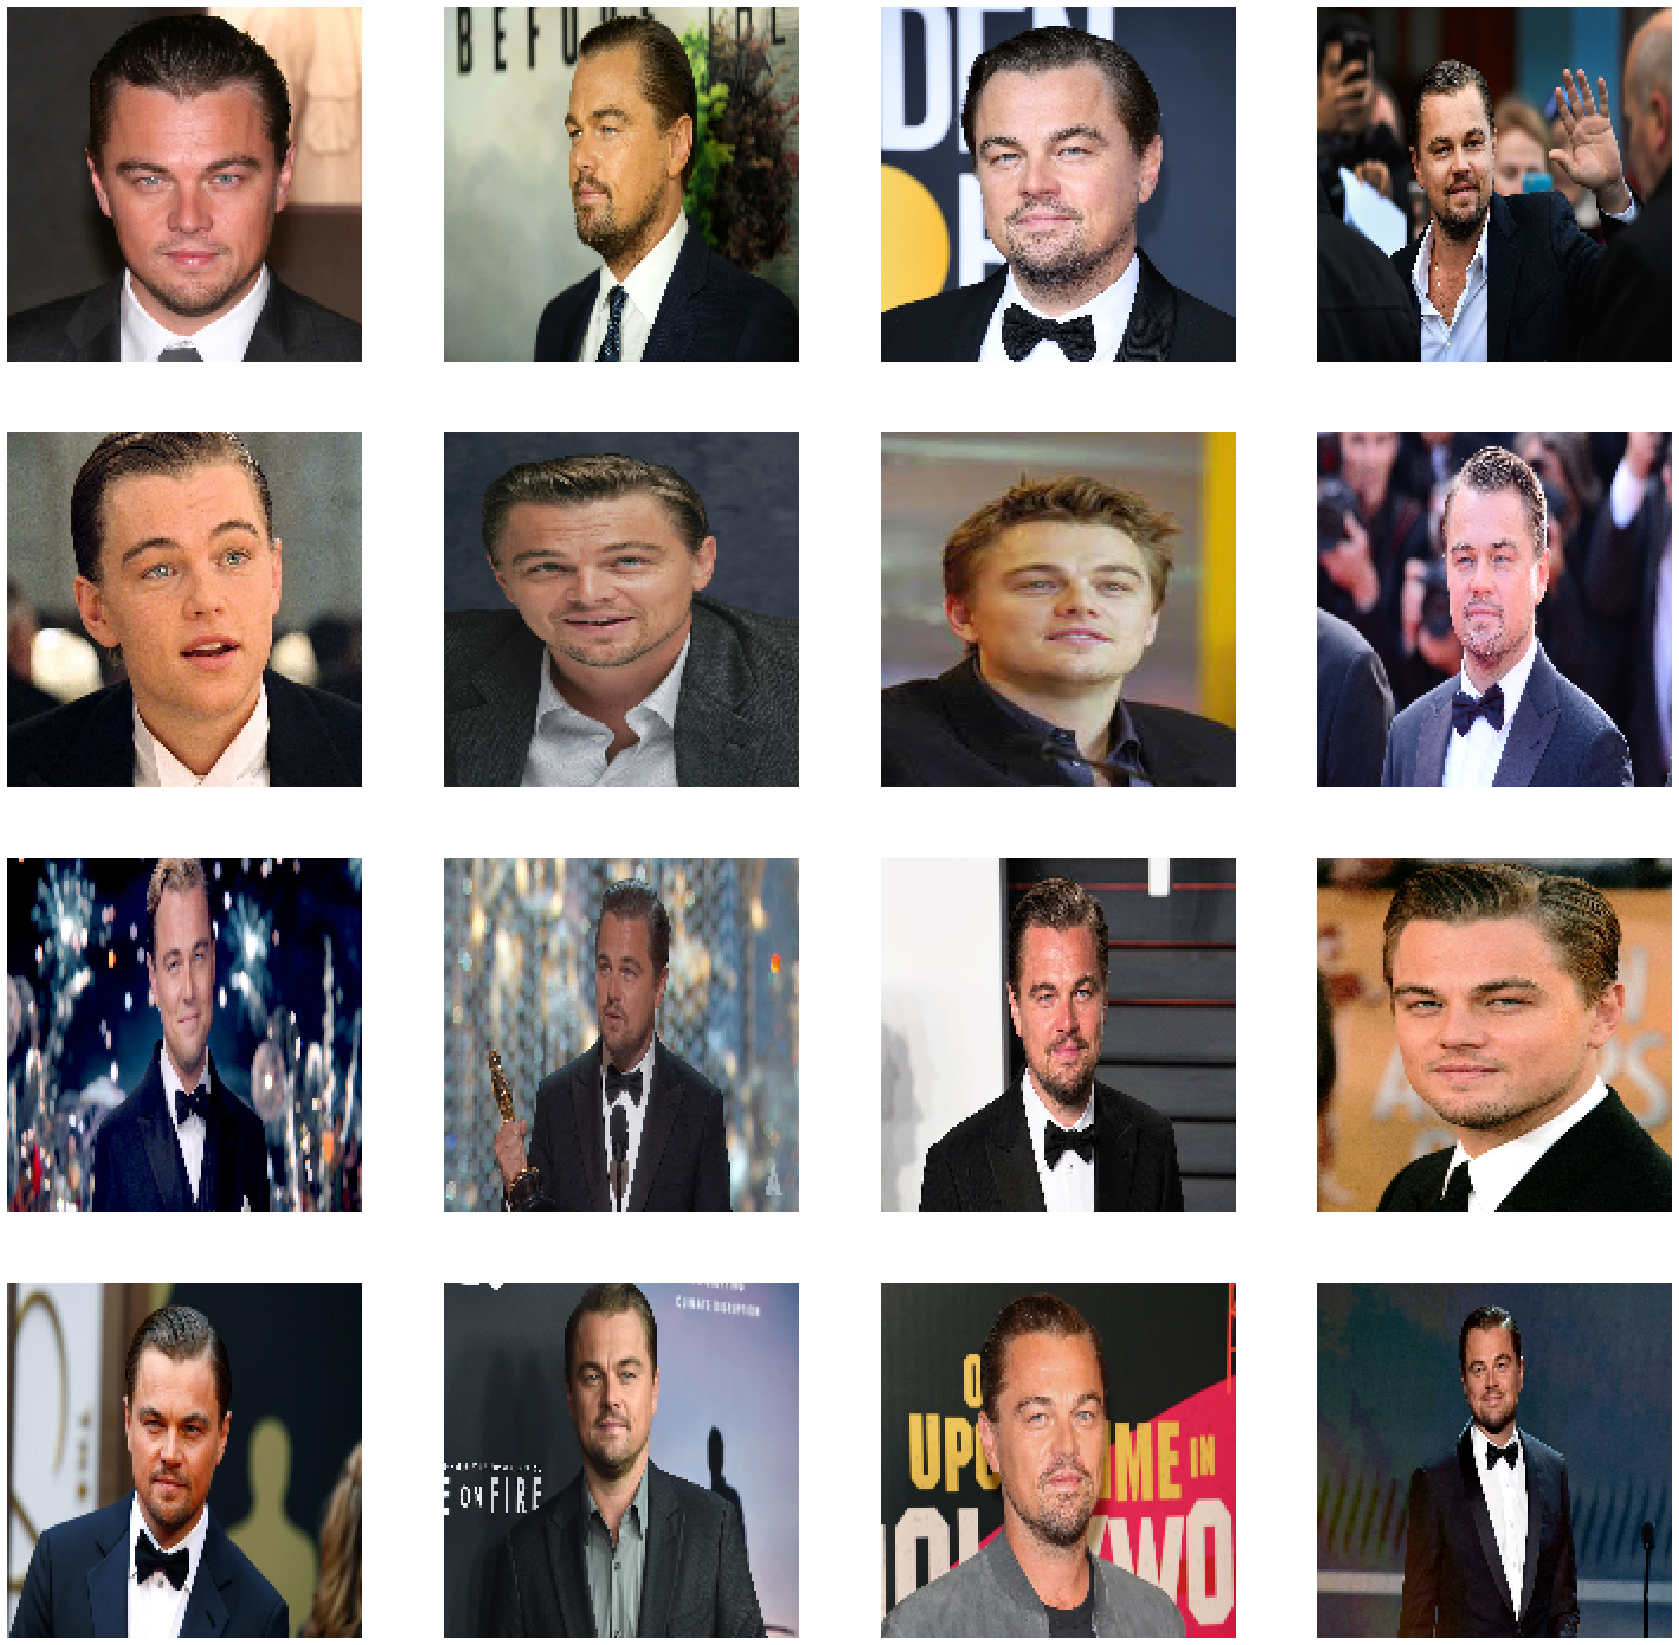

In [130]:
img_dir = os.path.join('D:/Learning/Data_Science_Mini_Project/Face_Recognition/train/leonardo_dicaprio')

leo_image = listdir(img_dir)[0:16]
visualize_images(leo_image, img_dir)

Now we have several images of Leonardo DiCaprio as you have seen above. However, in order to make the algorithm more robust, it is better if we get rid of unnecessary landmarks in the images, i.e we should only focus on Leo's face and get rid all of the backgrounds. To do this, we are going to use the MTCNN model to detect person's face from an image, draw a bounding box on it, and after the person's face is detected, then we can crop the image such that the final image only focus on person's face.

To do this particular task, let's define a function.

In [7]:
from os import listdir
from PIL import Image
from numpy import asarray
from matplotlib import pyplot
from mtcnn.mtcnn import MTCNN

def extract_face(filename, required_size=(96, 96)):
    
    image = Image.open(filename)
    
    image = image.convert('RGB')
    
    pixels = asarray(image)
    
    detector = MTCNN()

    results = detector.detect_faces(pixels)
    
    x1, y1, width, height = results[0]['box']

    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
  
    face = pixels[y1:y2, x1:x2]
    
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = asarray(image)
    img = np.expand_dims(face_array, axis=0)
    img = preprocess_input(img)
    return img

Next, we call the function above and transform all of the images such that all of the images now only focus on the person's face

In [ ]:
directory = ['leonardo_dicaprio/', 'sandra_bullock/', 'emma_stone/', 'brad_pitt/']

for dir_ in directory:
    save_dir =  os.path.join('D:/Learning/Data_Science_Mini_Project/Face_Recognition/train_face/',dir_)
    img_dir = os.path.join('D:/Learning/Data_Science_Mini_Project/Face_Recognition/train/',dir_)
    os.makedirs(save_dir)


    for filename in listdir(train_dir):

        path = train_dir + filename
 
        face = extract_face(path)
 
        image = Image.fromarray(face)
        save_path = save_dir + filename
        image.save(save_path)

Now let's visualize the resulting images after we preprocess them.

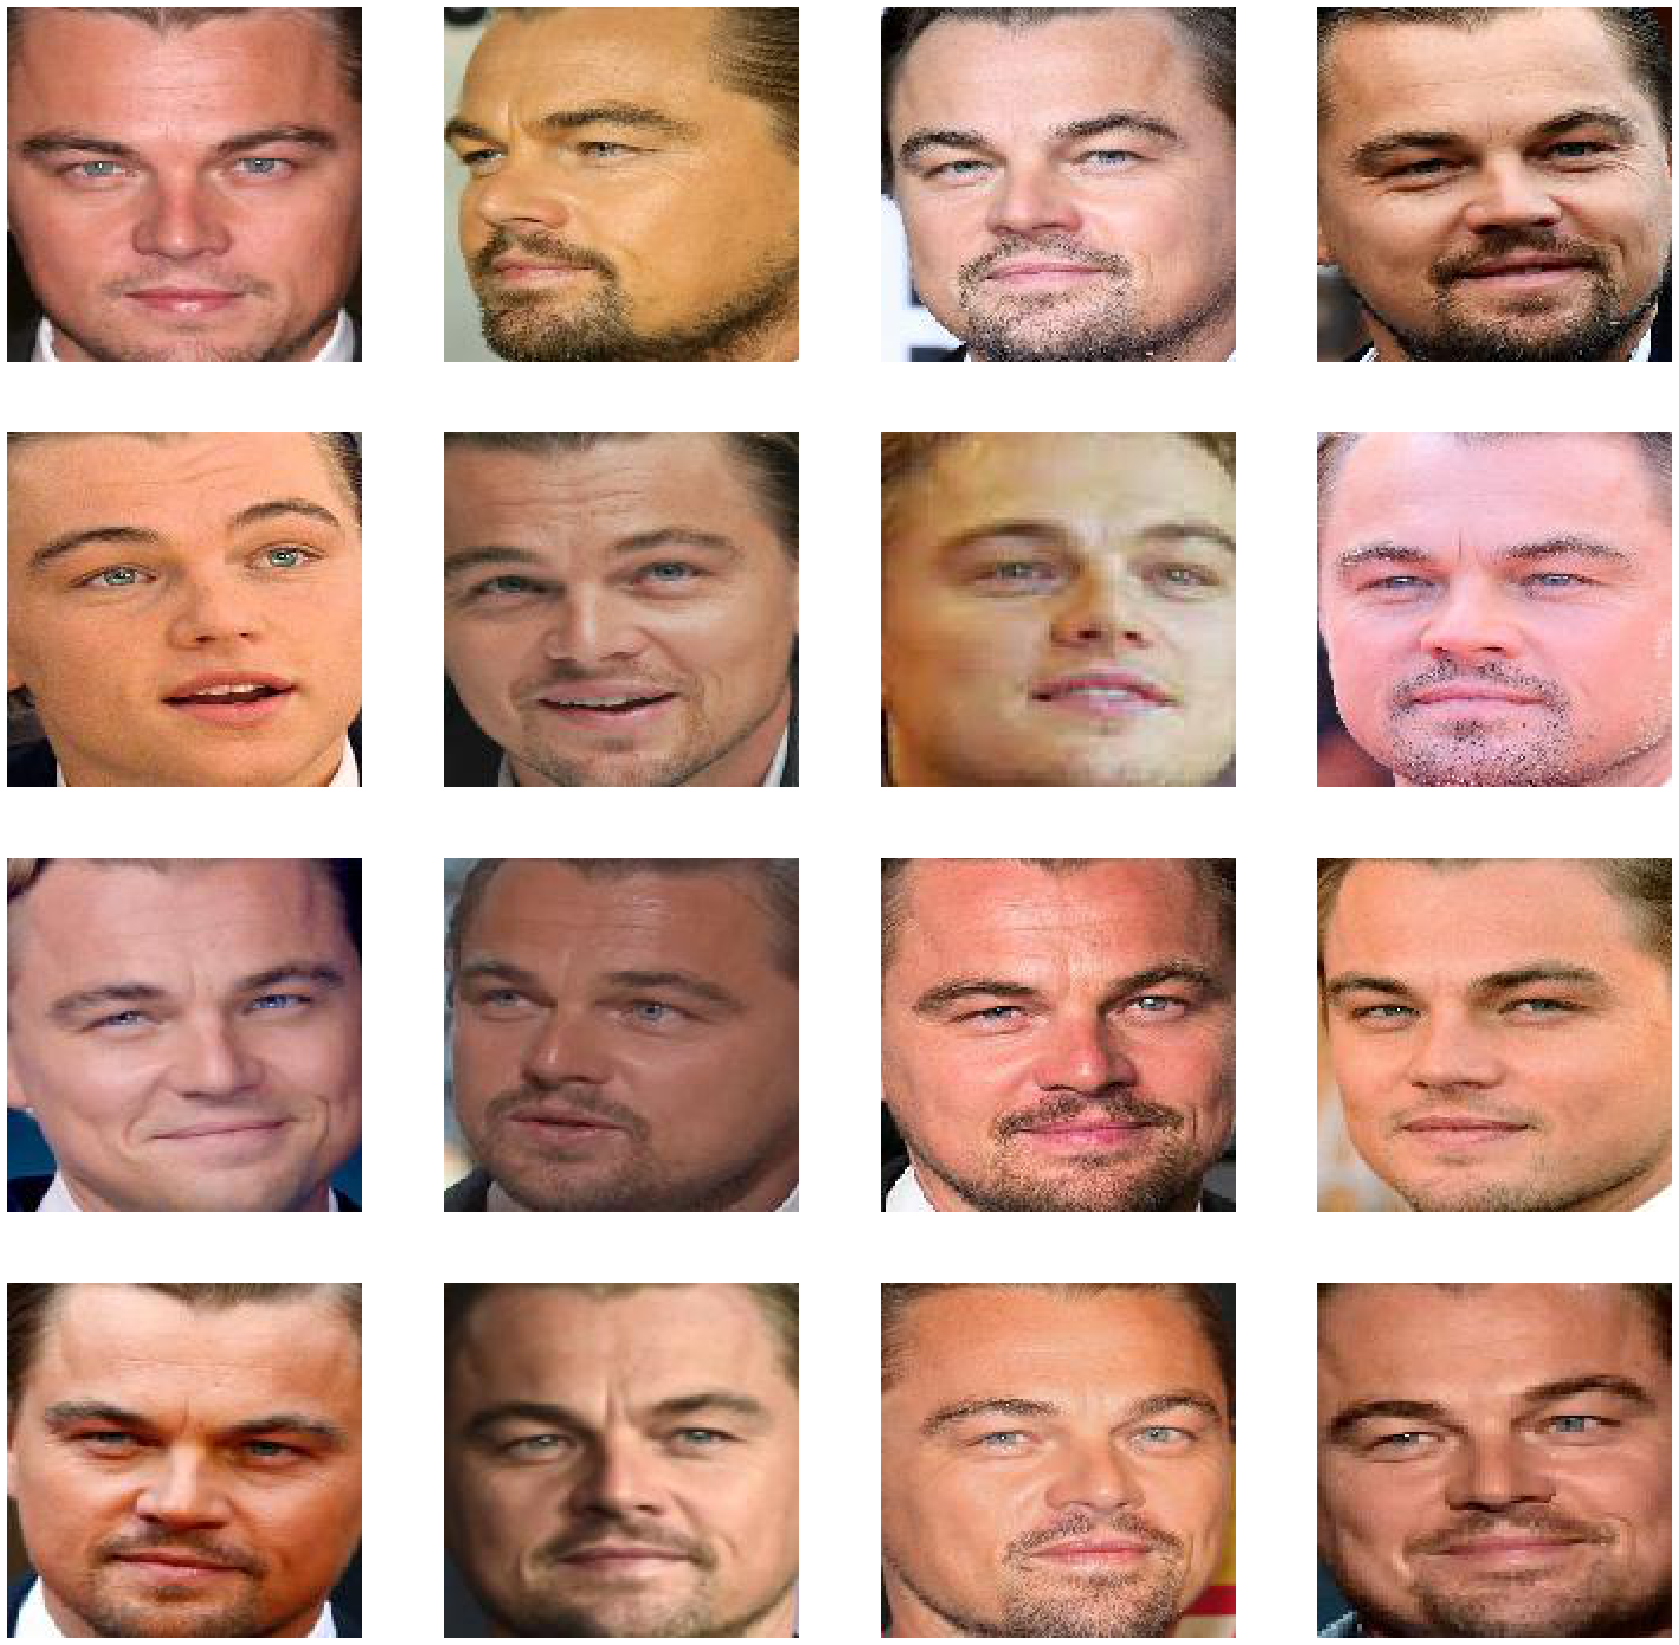

In [133]:
img_dir = os.path.join('D:/Learning/Data_Science_Mini_Project/Face_Recognition/train_face/leonardo_dicaprio')

leo_image = listdir(img_dir)[0:16]
visualize_images(leo_image, img_dir)

The result looks good! Now we have pictures which only contain the person's face. This will make the algorithm using triplet loss function more robust since we throw away unnecessary features in the images.

## Predicting Images

Now it's time for use to predict the unseen images. But before we actually predict the unseen images, we need to define first on how should we compute whether a person in an image is the same as one of Leonardo DiCaprio, Sandra Bullock, Emma Stone, or Brad Pitt. As a metrics, we are going to use the L2 distance between two images. Since this is face recognition task, then the embedding of an unseen image will be compared to the embedding of images that have been stored in the database. 

Let's define a function to calculate L2 distance.

In [8]:
def L2_distance(source, test):
    
    dist = np.linalg.norm(test-source)
    
    return dist

Next, let's predict the embedding of the images that we already own using OpenFace pre-trained model. Next, all of this embeddings will be compared to an unseen image.

In [9]:
artist_data = {}

artist_name = ["Leonardo DiCaprio", "Brad Pitt", "Sandra Bullock", "Emma Stone"]

In [10]:
directory = ['leonardo_dicaprio/', 'brad_pitt/', 'sandra_bullock/', 'emma_stone/']

for artist in range (len(artist_name)):
    
    img_dir =  os.path.join('D:/Learning/Data_Science_Mini_Project/Face_Recognition/train/',directory[artist])
    
    for filename in listdir(img_dir):

        path = img_dir + filename
        embedding = model.predict(extract_face(path))[0,:]
        artist_data.setdefault(artist_name[artist],[]).append(embedding)
        

C:\Users\ASUS\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:802: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


For sanity check, let's see what the embedding prediction looks like.

In [11]:
artist_data["Brad Pitt"][0]

array([-6.31266534e-02,  1.64835140e-01, -5.31583726e-02,  7.06470832e-02,
        2.35092733e-03,  7.74006322e-02, -1.88097749e-02, -6.23728707e-02,
        5.96701093e-02,  2.33744755e-02,  7.04805627e-02,  2.04567928e-02,
        4.33935560e-02, -1.61820638e-03, -3.37157189e-03,  1.46112284e-02,
        3.91547531e-02,  2.08085235e-02, -1.04376048e-01,  1.30431950e-01,
       -2.39746869e-02, -1.33843392e-01,  6.79883882e-02,  1.54965639e-01,
       -4.20229472e-02, -1.14079751e-01, -1.02253720e-01, -3.49600092e-02,
        6.78220205e-03, -5.88396518e-03,  1.07883207e-01,  1.00272454e-01,
        4.91259247e-02,  7.23940879e-02, -7.97513798e-02,  1.91643253e-01,
        5.82795329e-02,  9.85816047e-02, -1.59604251e-01,  4.48934585e-02,
        4.14850265e-02, -1.89685989e-02,  4.77800472e-03, -7.98481852e-02,
       -4.95335609e-02, -2.41506640e-02,  1.47319943e-01,  2.94891410e-02,
       -5.23889400e-02,  1.24232426e-01, -3.06239165e-02,  6.17693691e-03,
       -1.02121800e-01, -

Now it's time for us to do the fun part: predicting celeb images! To predict the images, first thing that we need to do is to create a function to predict the embedding of the input image and calculate the L2 distance between the embedding of input image and the embedding of images that we have in the database.

The image that has the lowest L2 distance will be picked as the true identity that most similar with the input image.

In [12]:
def who_is_it(artist_data, filename, model):

    min_dist = 100
    
    file_embedding = model.predict(extract_face(filename))[0,:]
    
    for (name, artist_embedding) in artist_data.items():
        
        for i in range (len(artist_embedding)//2):
            
            distance = L2_distance(file_embedding, artist_embedding[i])
        
            if distance < min_dist:
            
                min_dist = distance
                identity = name
        
    if min_dist > 0.5:
        print("No similar artist found")
    else:
        print ("it's " + str(identity) + ", the distance is " + str(min_dist))
        
    return min_dist, identity

Finally, we can predict the image right now!

it's Emma Stone, the distance is 0.13763802


(0.13763802, 'Emma Stone')

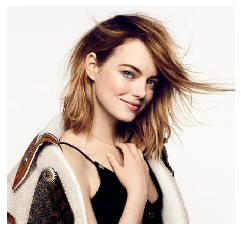

In [13]:
from PIL import Image

img = mpimg.imread("emma_1.jpg")
plt.imshow(img)
plt.axis('off')

who_is_it(artist_data, "emma_1.jpg", model)

it's Emma Stone, the distance is 0.085535415


(0.085535415, 'Emma Stone')

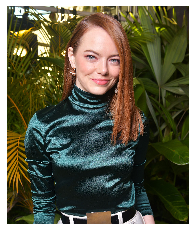

In [15]:
img = mpimg.imread("emma_3.jpg")
plt.imshow(img)
plt.axis('off')

who_is_it(artist_data, "emma_3.jpg", model)

it's Emma Stone, the distance is 0.10602085


(0.10602085, 'Emma Stone')

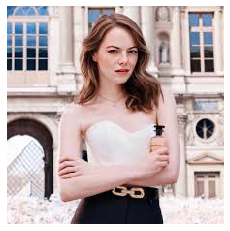

In [16]:
img = mpimg.imread("emma_5.jpg")
plt.imshow(img)
plt.axis('off')

who_is_it(artist_data, "emma_5.jpg", model)

it's Brad Pitt, the distance is 0.0


(0.0, 'Brad Pitt')

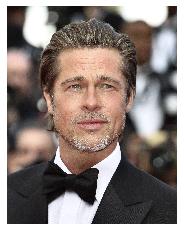

In [17]:
img = mpimg.imread("brad_1.jpg")
plt.imshow(img)
plt.axis('off')

who_is_it(artist_data, "brad_1.jpg", model)

it's Brad Pitt, the distance is 0.14527833


(0.14527833, 'Brad Pitt')

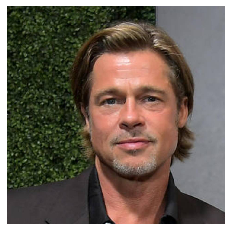

In [18]:
img = mpimg.imread("brad_3.jpg")
plt.imshow(img)
plt.axis('off')

who_is_it(artist_data, "brad_3.jpg", model)

it's Brad Pitt, the distance is 0.14699131


(0.14699131, 'Brad Pitt')

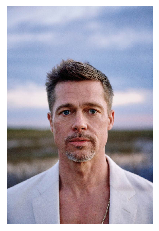

In [19]:
img = mpimg.imread("brad_5.jpg")
plt.imshow(img)
plt.axis('off')

who_is_it(artist_data, "brad_5.jpg", model)

it's Sandra Bullock, the distance is 0.10428941


(0.10428941, 'Sandra Bullock')

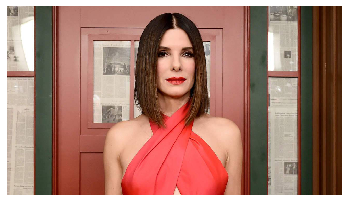

In [20]:
img = mpimg.imread("sandra_1.jpg")
plt.imshow(img)
plt.axis('off')

who_is_it(artist_data, "sandra_1.jpg", model)

it's Sandra Bullock, the distance is 0.13385016


(0.13385016, 'Sandra Bullock')

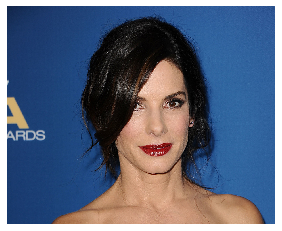

In [21]:
img = mpimg.imread("sandra_3.jpg")
plt.imshow(img)
plt.axis('off')

who_is_it(artist_data, "sandra_3.jpg", model)

it's Sandra Bullock, the distance is 0.09990987


(0.09990987, 'Sandra Bullock')

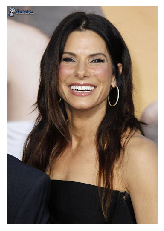

In [23]:
img = mpimg.imread("sandra_4.jpg")
plt.imshow(img)
plt.axis('off')

who_is_it(artist_data, "sandra_4.jpg", model)

it's Leonardo DiCaprio, the distance is 0.13795078


(0.13795078, 'Leonardo DiCaprio')

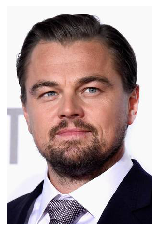

In [24]:
img = mpimg.imread("leo_1.jpg")
plt.imshow(img)
plt.axis('off')

who_is_it(artist_data, "leo_1.jpg", model)

it's Leonardo DiCaprio, the distance is 0.0


(0.0, 'Leonardo DiCaprio')

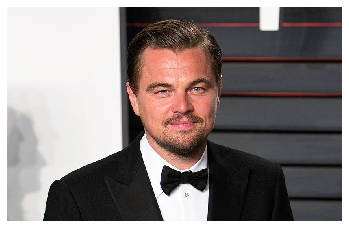

In [25]:
img = mpimg.imread("leo_3.jpg")
plt.imshow(img)
plt.axis('off')

who_is_it(artist_data, "leo_3.jpg", model)

it's Leonardo DiCaprio, the distance is 0.14540194


(0.14540194, 'Leonardo DiCaprio')

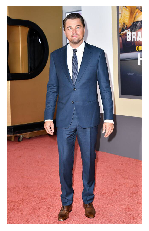

In [26]:
img = mpimg.imread("leo_5.jpg")
plt.imshow(img)
plt.axis('off')

who_is_it(artist_data, "leo_5.jpg", model)

An now we have it! The face recognition algorithm to recognize celebrity's face. The algorithm can be improved by adding more pictures of each celebrity in different lighting conditions, different angle, or even different haircut. Next, I want to apply this static face recognition algorithm to the dynamic one from a video. 